# **I. Perkenalan**

***
Live Code 4 Time Series

Nama  : Catherine Kezia Wijaya

Batch : RMT-037

File ipynb ini berisi pembuatan model machine learning Time Series yang dapat memprediksi popularitas wisata Pulau Pari.
***

## Pendahuluan

### Gambaran Dataset
Data merupakan informasi dari Google Trend tentang seberapa populer kata kunci `Pulau Pari` telah disearching di Google. Dataset terdapat dua kolom yaitu:

- Week: Data, berisi tanggal pertama di setiap minggu
- Pulau Pari: (Indonesia): berisi persentase popularitas maksimum dari kata kunci yang dicari. Pembagian persentasenya adalah:
    - 0 : tidak ada data,
    - 50 : popularitas hanya setengah,
    - 100 : sangat populer

### Objective
Sebagai data scientist di perusahaan travel agent, ingin membuat model machine learning Time Series untuk memprediksi bagaimana popularitas wisata Pulau Pari selama satu tahun ke depan. Dengan wawasan ini, bisa diberikan ke perusahaan untuk menyesuaikan strategi pemasaran supaya sesuai dengan popularitas market. 

Akan dibuat model dengan algoritma SARIMA dan ARIMA, performa model dinilai dengan metric regresi yaitu Mean Absolute Error (MAE) dan R Squared, dan juga nilai entropi AIC

# **II. Import Libraries**

In [1]:
# Import library

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
# Check the MAE & MAPE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# **III. Data Loading**

In [2]:
df_ori = pd.read_csv('multiTimeline.csv', header=1)
df = df_ori.copy()
df

,Week,Pulau Pari: (Indonesia)
0,2022-03-27,16
1,2022-04-03,13
2,2022-04-10,18
3,2022-04-17,29
4,2022-04-24,35
...,...,...
121,2024-07-21,43
122,2024-07-28,34
123,2024-08-04,32
124,2024-08-11,36


In [3]:
# Check info dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Week                     126 non-null    object
 1   Pulau Pari: (Indonesia)  126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


- Terdapat 126 baris data dan 2 kolom, yaitu `Week` dan `Pulau Pari : (Indonesia)`
- Kolom `Week` adalah data waktu, tetapi memiliki tipe data String
- Nama `Pulau Pari : (Indonesia)` terlalu panjang, perlu diperpendek

In [4]:
df.isnull().sum()

Week                       0
Pulau Pari: (Indonesia)    0
dtype: int64

Tidak ada data kosong

>Mengubah nama kolom, dan tipe data tanggal

In [5]:
df.columns = ['date', 'persentase_search']
df.date = pd.to_datetime(df.date)

>Mengubah kolom tanggal menjadi index data

In [6]:
df.set_index('date',inplace=True)

# **IV. Exploratory Data Analysis (EDA)**

## 1. Menunjukkan visualisasi data

Text(0, 0.5, 'persentase search')

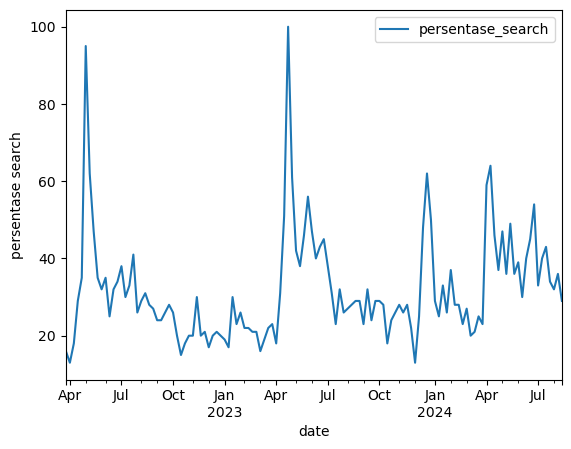

In [7]:
# Plot the data
df.plot()
plt.xlabel('date')
plt.ylabel('persentase search')

## 2. Time Series Decomposition

### Additive

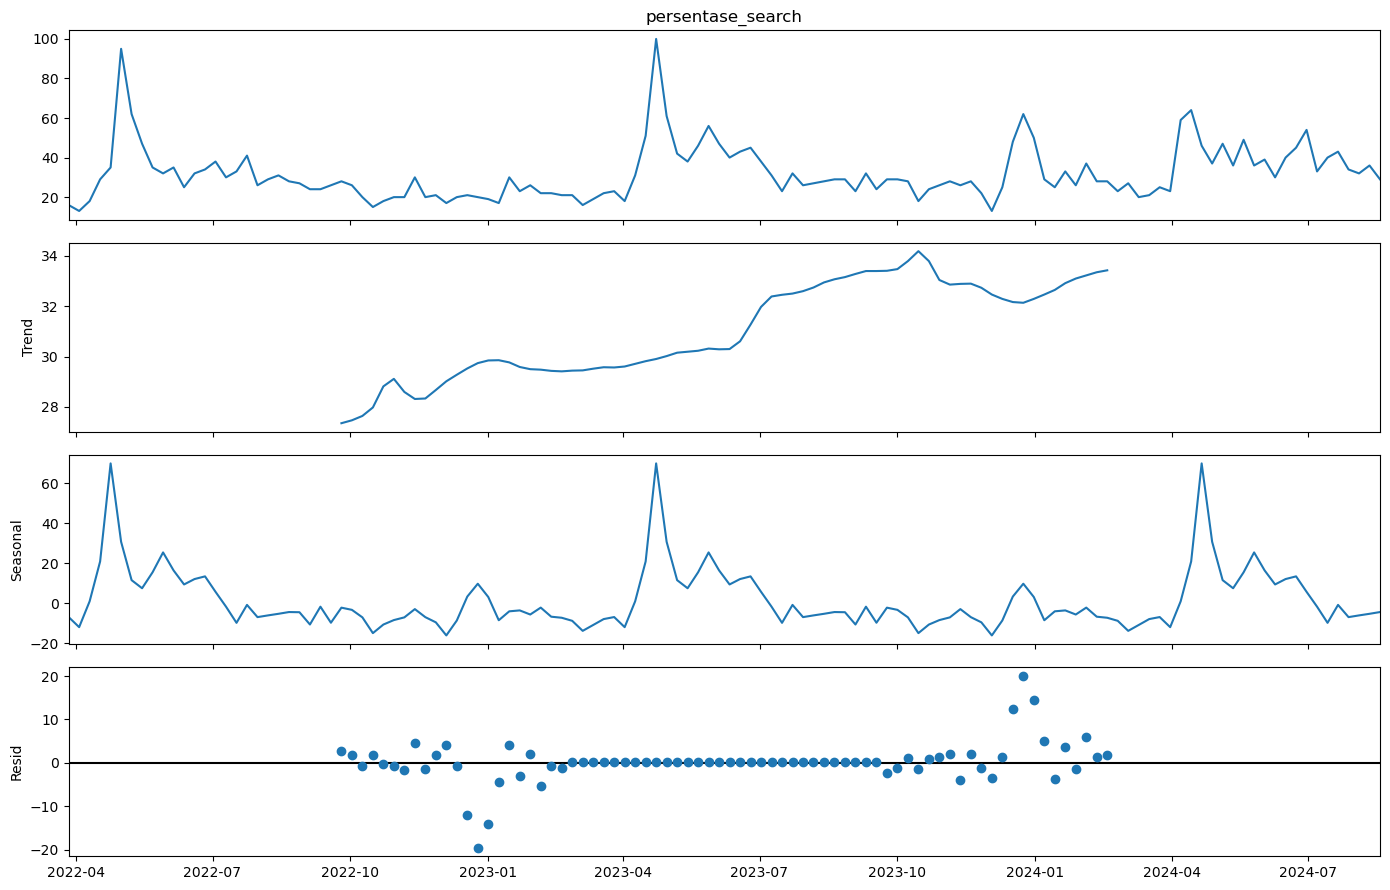

In [8]:
# Decompose the components from the time series.

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df['persentase_search'], model='additive', period=52) #ubah - ubah model, lihat residual
ax=res.plot()
plt.show()

Dari grafik residual, ada banyak nilai di dekat nilai 0 akan tetapi ada yang bernilai sampai 20 atau bahkan sampai 40. Model ini mungkin kurang tepat

### Multiplicative

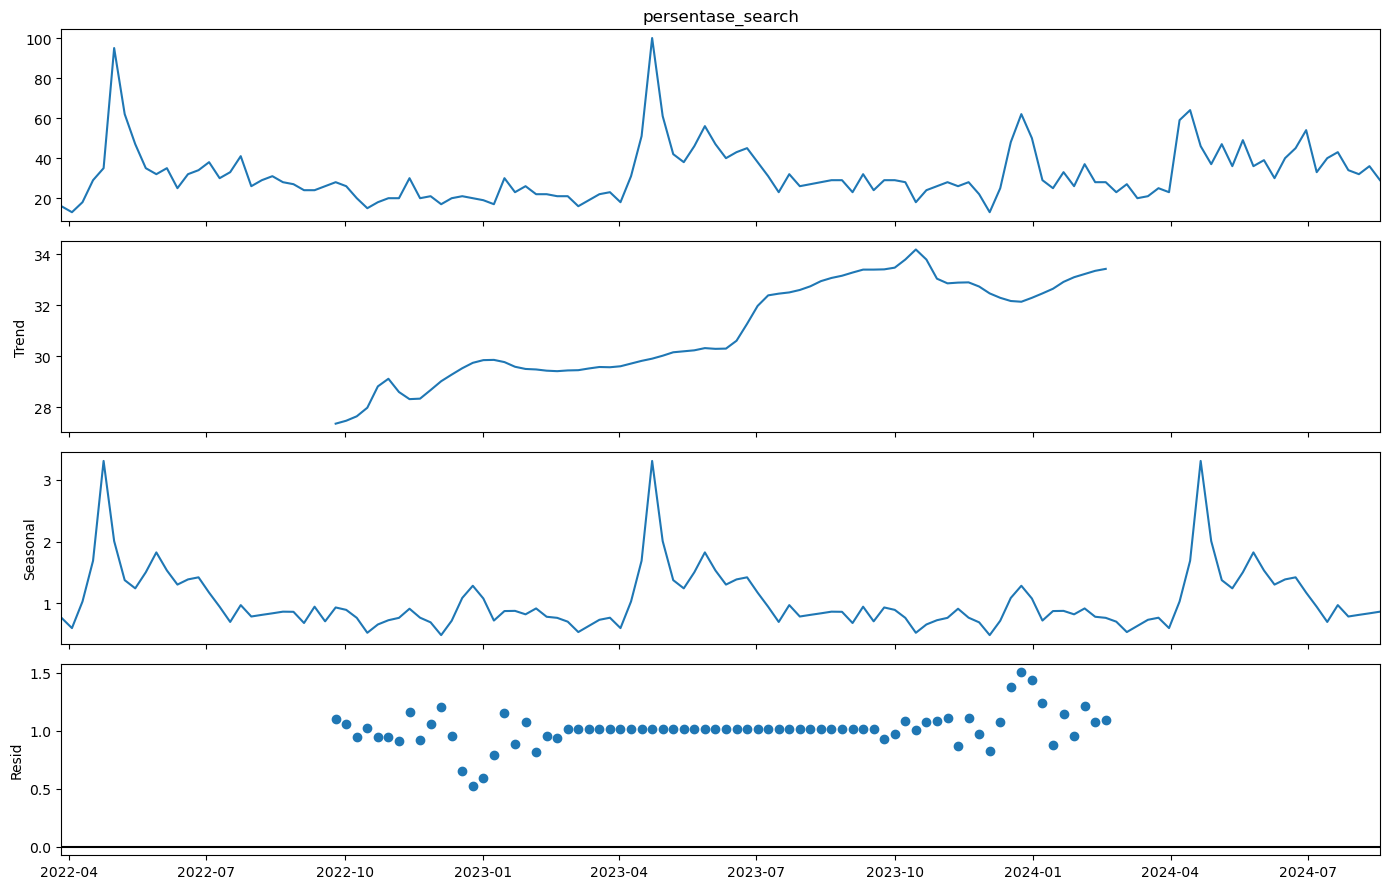

In [9]:
# Decompose the components from the time series.

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df['persentase_search'], model='multiplicative', period=52) #ubah - ubah model, lihat residual
ax=res.plot()
plt.show()

Terdapat dua visualisasi, di bagian atas menggunakan model `Additive` bagian bawah menggunakan model `Multiplicative`. Dari kedua visualisasi, di bagian paling bawah terdapat grafik residu. Model terbaik dipilih dari nilai residu yang mendekati 0, dari grafik ditentukan bahwa `Multiplicative` adalah model terbaik. Periode diisi nilai 52, karena data diambil setiap minggu, dan diminta untuk memprediksi selama satu tahun. Jumlah minggu dalam satu tahun adalah 52

## 3. Stationary

Pemeriksaan Stationary data dan melakukan Differencing jika diperlukan

### Without Differencing

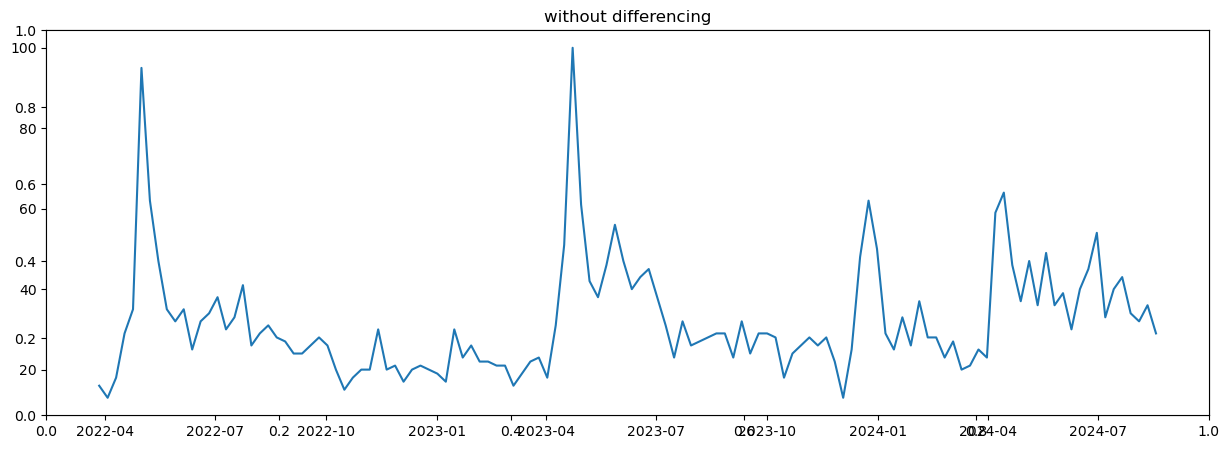

In [10]:
# Plot without differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('without differencing')
ax1.plot(df['persentase_search'])

In [11]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [12]:
# Check stationarity of the dataset

check_stationarity(df['persentase_search'])

ADF Statistic: -3.893116
p-value: 0.002086
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580
Stationary


Tanpa melakukan differencing sudah stationary

## 4. ACF & PCF

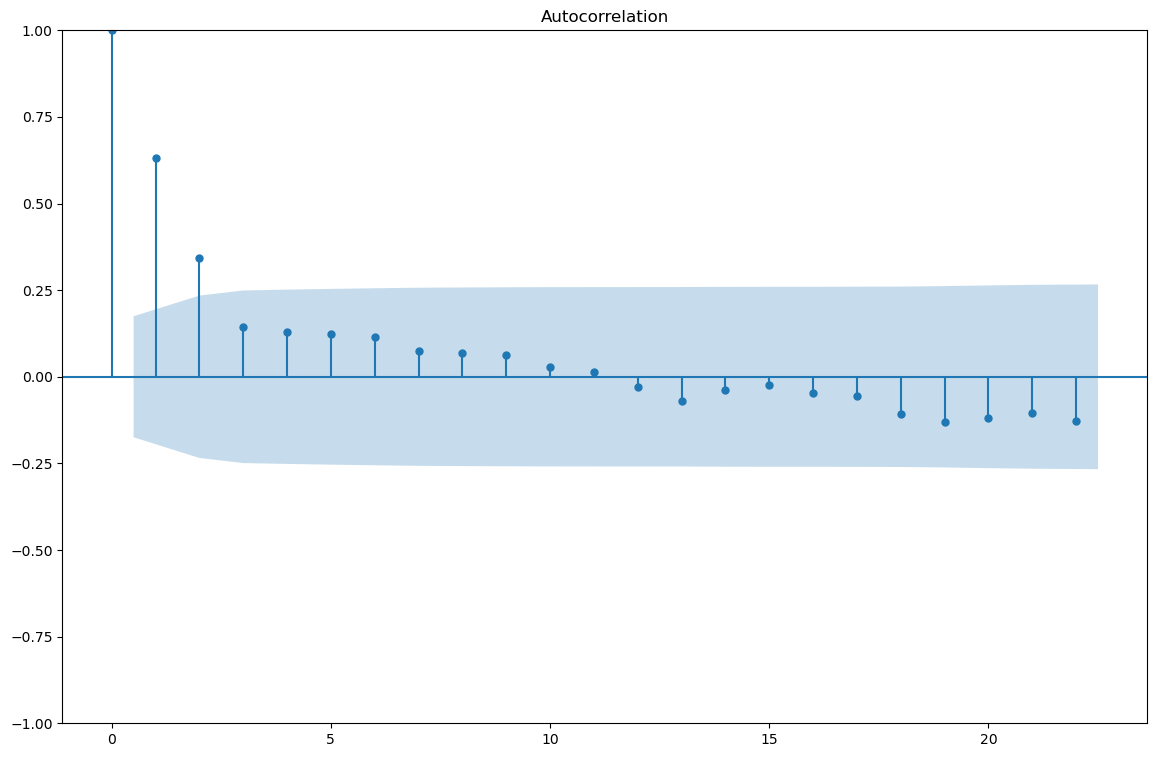

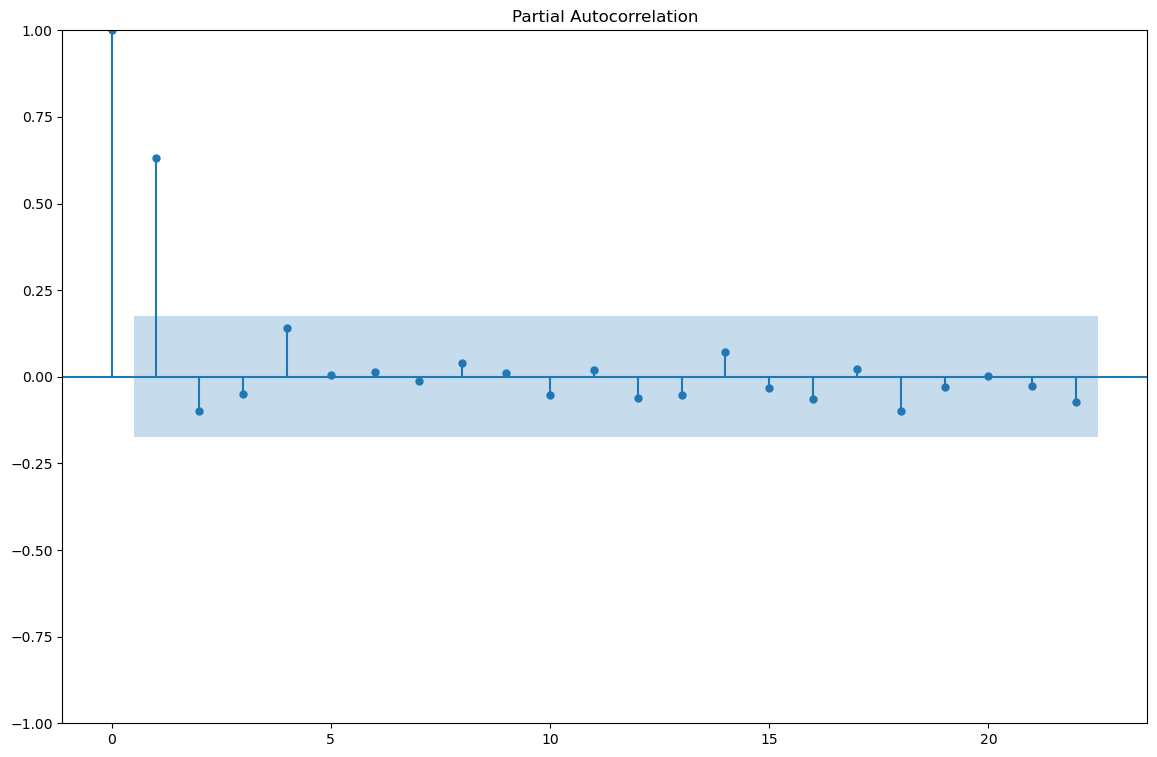

In [13]:
# Plot ACF & PACF from the original dataset

plot_acf(df['persentase_search'])
plot_pacf(df['persentase_search'])
plt.show()

- Dari Autocorrelation terdapat 3 baris sebelum masuk interval, maka ACF bernilai 2
- Dari Partial Autocorrelation terdapat 1 baris sebelum masuk interval, paka PACF bernilai 1

Dari sini ditentukan bahwa nilai p adalah 1 , nilai q adalah 2 dan karena tidak dilakukan differencing maka nilai d adalah 0

# **V. Model Definition and Training**

## A. ARIMA

In [14]:
#menampilkan ukuran data
len(df)

126

Data displit menjadi train dan test

In [15]:
# Splitting dataset

train = df[:94]
test = df[94:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (94, 1)
Test size :  (32, 1)


Memeriksa apakah data sudah stationary

In [16]:
# Stationarity check

check_stationarity(train['persentase_search'])

ADF Statistic: -3.286548
p-value: 0.015491
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584
Stationary


Data sudah stationary

In [ ]:
# Train with p=1, d=0, q=2

arima = ARIMA(train, order=(1, 0, 2))
mod_train = arima.fit()
mod_train.aic

724.9832776523458

Nilai AIC kecil, model cukup bagus

Melakukan prediksi pada data test

In [18]:
print(test.index.min())
print(test.index.max())

2024-01-14 00:00:00
2024-08-18 00:00:00


Prediksi mulai dari tanggal 2024-01-14 sampai 2024-08-18

In [19]:
## Predict test-set
ari_pred_test = mod_train.predict(start=test.index.min(), end=test.index.max(), dynamic=True)
ari_pred_test = pd.DataFrame(ari_pred_test)
ari_pred_test.columns = ['persentase_search_predict']

## Concate with actual test-set
act_vs_pred_ari=pd.concat([test, ari_pred_test], axis=1)
act_vs_pred_ari.head(10)

,persentase_search,persentase_search_predict
2024-01-14,25,24.247129
2024-01-21,33,25.798747
2024-01-28,26,29.530926
2024-02-04,37,30.267441
2024-02-11,28,30.412786
2024-02-18,28,30.441468
2024-02-25,23,30.447129
2024-03-03,27,30.448246
2024-03-10,20,30.448466
2024-03-17,21,30.448510


Visualisasi hasil prediksi

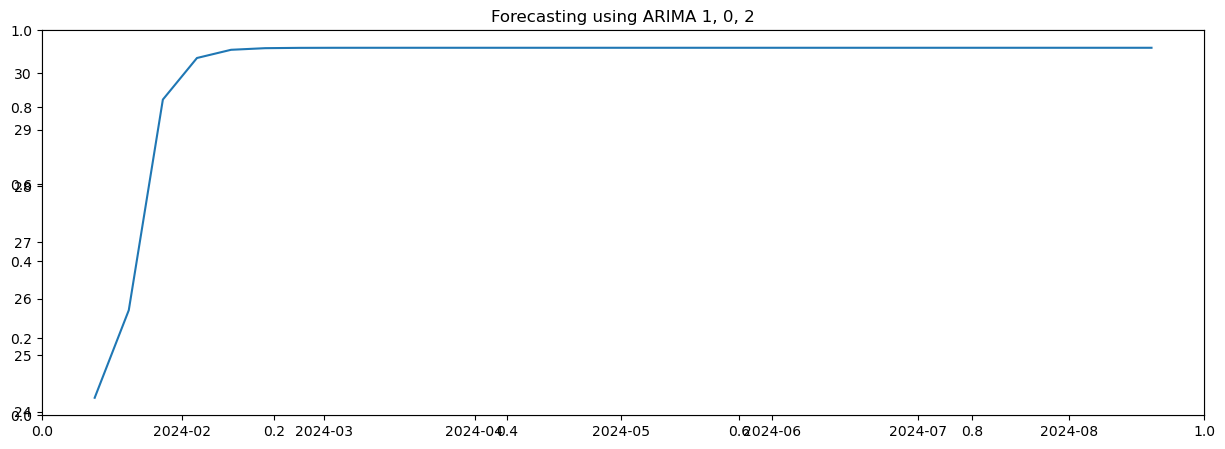

In [20]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using ARIMA 1, 0, 2')
ax1.plot(ari_pred_test)

Hasilnya kurang bagus, nilai terus meningkat dan stuck pada 30.412

In [21]:
print('MAE test  : ', mean_absolute_error(test, ari_pred_test))
print('MAPE test : ', mean_absolute_percentage_error(test, ari_pred_test))

MAE test  :  9.080778952565463
MAPE test :  0.23328750201037646


Nilai MAE 9, dan MAPE 0.48 menunjukkan bahwa performa model masih kurang bagus dan memiliki banyak kesalahan dalam memprediksi. Model bisa memprediksi sekitar 77% dari dari data dengan benar

## B. SARIMA

In [22]:
# Splitting dataset

train = df[:94]
test = df[94:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (94, 1)
Test size :  (32, 1)


Menampilkan data pada train dan test

In [23]:
#display train set
train

,persentase_search
date,
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
2022-04-24,35
...,...
2023-12-10,25
2023-12-17,48
2023-12-24,62


In [24]:
#display train set
test

,persentase_search
date,
2024-01-14,25
2024-01-21,33
2024-01-28,26
2024-02-04,37
2024-02-11,28
2024-02-18,28
2024-02-25,23
2024-03-03,27
2024-03-10,20


In [25]:
# Train using SARIMAX


sar=SARIMAX(train, order=(1, 0, 2),seasonal_order=(1, 0, 2, 52)).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  persentase_search   No. Observations:                   94
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 52)   Log Likelihood                -365.283
Date:                            Mon, 18 Nov 2024   AIC                            744.566
Time:                                    12:01:39   BIC                            762.369
Sample:                                03-27-2022   HQIC                           751.757
                                     - 01-07-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9834      0.043     23.139      0.000       0.900       1.067
ma.L1         -0.2607      0.165     -1.583      0.113      -0.583       0.062
ma.L2         -0.3035      0.233     -1.301      0.193      -0.761       0.154
ar.S.L52       0.8526    238.985      0.004      0.997    -467.550     469.255
ma.S.L52      -1.3785    429.736     -0.003      0.997    -843.646     840.889
ma.S.L104      0.9610    147.547      0.007      0.995    -288.225     290.147
sigma2        60.6579      9.757      6.217      0.000      41.534      79.782
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):              1051.50
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             3.28
Prob(H) (two-sided):                  0.01   Kurtosis:                        18.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+20. Standard errors may be unstable.
"""

- Menurut nilai Sigma, data tidak terlalu bervariasi
- Nilai H 0.35 dan P-value 0.01 menandakan sifat heteroskedascity, model perlu diperbaiki lebih lanjut untuk meningkatkan performa
- p, d, q sesuai dengan analisis decomposition dan ACF&PCF

In [26]:
sar.aic

744.5662110146171

Sama dengan ARIMA, nilai AIC kecil, model terlihat cukup bagus

In [27]:
## Predict test-set
sar_pred_test = sar.predict(start=test.index.min(), end=test.index.max(), dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['persentase_search_predict']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([test, sar_pred_test], axis=1)
act_vs_pred_sar

,persentase_search,persentase_search_predict
2024-01-14,25,31.614325
2024-01-21,33,35.056746
2024-01-28,26,34.661237
2024-02-04,37,34.197229
2024-02-11,28,33.787312
2024-02-18,28,33.375597
2024-02-25,23,32.984282
2024-03-03,27,32.546325
2024-03-10,20,32.206641
2024-03-17,21,30.779747


In [28]:
# Check the MAE & RMSE

print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
print('MAPE test : ', mean_absolute_percentage_error(test, sar_pred_test))

MAE test  :  8.714303417425759
MAPE test :  0.2358068403547353


Nilai MAE sebesar 8.7 dan MAPE 23%, menunjukkan bahwa model bisa memprediksi dengan benar sebanyak 77% dari data

Visualisasi hasil prediksi SARIMA

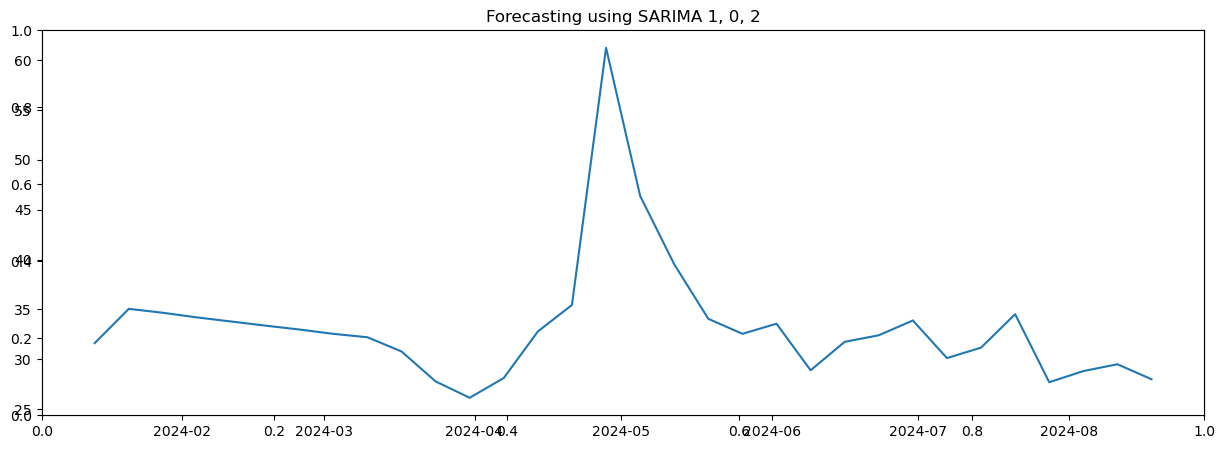

In [29]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using SARIMA 1, 0, 2')
ax1.plot(sar_pred_test)

Persentase relatif rendah, tetapi terdapat kenaikan secara signifikan diantara bulan april sampai akhir bulan mei

# **VI Model Evaluation**

## Evaluasi Model
Setelah dibuat dan dilakukan prediksi menggunakan Model ARIMA dan SARIMA berikut yang didapat:
- Nilai MAE dan MAPE pada model SARIMA lebih sedikit dari model ARIMA, tetapi tidak signifikan, hal ini menunjukkan bahwa akurasi model SARIMA dan ARIMA kurang lebih sama
- Dari hasil prediksi, ARIMA terus menerus meningkat hingga stuck pada nilai 30.412. Hal ini dikarenakan cara kerja ARIMA yang menangkap pola secara stasioner. Begitu trend terlihat naik, maka sisanya akan terus menerus naik tanpa menghiraukan naik turunnya data
- SARIMA lebih fleksibel, data mengenali pola dengan parameter musiman, model lebih fleksibel dan bisa mengenali pola naik turun, sehingga prediksi lebih akurat.

Dari analisis ini, model yang dipilih adalah SARIMA, akan tetapi masih ada kesalahan prediksi sekitar 20% dari data perlu ada perbaikan lagi

## Evaluasi Bisnis
Dari hasil model SARIMA, trend searching Pulau Pari relatif rendah, tetapi terjadi kenaikkan signifikan di bulan tertentu seperti April sampai akhir Mei. Mungkin menjadi populer karena cuaca di bulan itu tidak terlalu dingin juga tidak terlalu panas. Lebih baik perusahaan mulai menargetkan pemasaran pariwisata Pulau Pari di April - Mei ini

# IX. Inference

prediksi 1 tahun setelah index akhir data test

In [30]:
sar_pred_inf = sar.predict(start='2024-08-19', end='2025-08-19', dynamic=True)
sar_pred_inf = pd.DataFrame(sar_pred_inf)
sar_pred_inf.columns = ['persentase_search_predict']
sar_pred_inf

,persentase_search_predict
2024-08-25,27.363968
2024-09-01,25.824661
2024-09-08,25.699538
2024-09-15,26.349493
2024-09-22,27.084978
2024-09-29,26.038527
2024-10-06,23.235138
2024-10-13,20.818054
2024-10-20,22.014513
2024-10-27,22.751144
